In [1]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pysal as ps
import geopandas as gpd
from sklearn import cluster
from sklearn.preprocessing import scale
from datetime import datetime
from geopandas import GeoDataFrame
from shapely.geometry import Point
from geopandas.tools import overlay

sns.set(style="whitegrid")

In [2]:
requests_link = "./data/311_requests.csv"
requests = pd.read_csv(requests_link)

# almost 18,000 requests are being geocoded to the same place
tmp = requests.groupby('Latitude').count().sort_values(by='open_dt',ascending=False)

# pull out those requests and take it out for now
odd = requests.loc[requests.Latitude==42.3594, ['Longitude', 'Latitude']]
requests_tmp = requests.drop(odd.index)

In [3]:
requests_tmp.head()

,CASE_ENQUIRY_ID,open_dt,target_dt,closed_dt,OnTime_Status,CASE_STATUS,CASE_TITLE,SUBJECT,REASON,TYPE,QUEUE,Department,Latitude,Longitude,Source
1,101002075588,2017-04-29 00:02:07,2017-05-02 08:30:00,NaN,ONTIME,Open,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,Parking Enforcement,BTDT_Parking Enforcement,BTDT,42.3361,-71.1095,Citizens Connect App
2,101002075587,2017-04-28 23:55:28,2017-05-02 08:30:00,NaN,ONTIME,Open,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,Parking Enforcement,BTDT_Parking Enforcement,BTDT,42.3331,-71.0535,Citizens Connect App
3,101002075585,2017-04-28 23:15:15,2017-05-08 08:30:00,NaN,ONTIME,Open,Litter / Ground Maintenance - Peters Park (BPRD),Parks & Recreation Department,Park Maintenance & Safety,Ground Maintenance,PARK_Maintenance_Region 5,PARK,42.3431,-71.0683,Citizens Connect App
4,101002075578,2017-04-28 23:03:20,2017-05-02 08:30:00,NaN,ONTIME,Open,Sidewalk Repair (Make Safe),Public Works Department,Highway Maintenance,Sidewalk Repair (Make Safe),PWDx_Contractor Complaints,PWDx,42.3421,-71.0835,Citizens Connect App
5,101002075577,2017-04-28 23:02:50,2017-05-02 08:30:00,NaN,ONTIME,Open,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,Parking Enforcement,BTDT_Parking Enforcement,BTDT,42.3571,-71.0602,Citizens Connect App


In [4]:
requests_tmp['closed_dt'].fillna("2017-04-30 00:00:00", inplace=True)
requests_tmp.head()

,CASE_ENQUIRY_ID,open_dt,target_dt,closed_dt,OnTime_Status,CASE_STATUS,CASE_TITLE,SUBJECT,REASON,TYPE,QUEUE,Department,Latitude,Longitude,Source
1,101002075588,2017-04-29 00:02:07,2017-05-02 08:30:00,2017-04-30 00:00:00,ONTIME,Open,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,Parking Enforcement,BTDT_Parking Enforcement,BTDT,42.3361,-71.1095,Citizens Connect App
2,101002075587,2017-04-28 23:55:28,2017-05-02 08:30:00,2017-04-30 00:00:00,ONTIME,Open,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,Parking Enforcement,BTDT_Parking Enforcement,BTDT,42.3331,-71.0535,Citizens Connect App
3,101002075585,2017-04-28 23:15:15,2017-05-08 08:30:00,2017-04-30 00:00:00,ONTIME,Open,Litter / Ground Maintenance - Peters Park (BPRD),Parks & Recreation Department,Park Maintenance & Safety,Ground Maintenance,PARK_Maintenance_Region 5,PARK,42.3431,-71.0683,Citizens Connect App
4,101002075578,2017-04-28 23:03:20,2017-05-02 08:30:00,2017-04-30 00:00:00,ONTIME,Open,Sidewalk Repair (Make Safe),Public Works Department,Highway Maintenance,Sidewalk Repair (Make Safe),PWDx_Contractor Complaints,PWDx,42.3421,-71.0835,Citizens Connect App
5,101002075577,2017-04-28 23:02:50,2017-05-02 08:30:00,2017-04-30 00:00:00,ONTIME,Open,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,Parking Enforcement,BTDT_Parking Enforcement,BTDT,42.3571,-71.0602,Citizens Connect App


In [5]:
requests_tmp['open_dt_date'] = pd.to_datetime(requests_tmp['open_dt'], format="%Y-%m-%d %H:%M:%S")
requests_tmp['closed_dt_date'] = pd.to_datetime(requests_tmp['closed_dt'], format="%Y-%m-%d %H:%M:%S")
requests_tmp.head()

,CASE_ENQUIRY_ID,open_dt,target_dt,closed_dt,OnTime_Status,CASE_STATUS,CASE_TITLE,SUBJECT,REASON,TYPE,QUEUE,Department,Latitude,Longitude,Source,open_dt_date,closed_dt_date
1,101002075588,2017-04-29 00:02:07,2017-05-02 08:30:00,2017-04-30 00:00:00,ONTIME,Open,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,Parking Enforcement,BTDT_Parking Enforcement,BTDT,42.3361,-71.1095,Citizens Connect App,2017-04-29 00:02:07,2017-04-30
2,101002075587,2017-04-28 23:55:28,2017-05-02 08:30:00,2017-04-30 00:00:00,ONTIME,Open,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,Parking Enforcement,BTDT_Parking Enforcement,BTDT,42.3331,-71.0535,Citizens Connect App,2017-04-28 23:55:28,2017-04-30
3,101002075585,2017-04-28 23:15:15,2017-05-08 08:30:00,2017-04-30 00:00:00,ONTIME,Open,Litter / Ground Maintenance - Peters Park (BPRD),Parks & Recreation Department,Park Maintenance & Safety,Ground Maintenance,PARK_Maintenance_Region 5,PARK,42.3431,-71.0683,Citizens Connect App,2017-04-28 23:15:15,2017-04-30
4,101002075578,2017-04-28 23:03:20,2017-05-02 08:30:00,2017-04-30 00:00:00,ONTIME,Open,Sidewalk Repair (Make Safe),Public Works Department,Highway Maintenance,Sidewalk Repair (Make Safe),PWDx_Contractor Complaints,PWDx,42.3421,-71.0835,Citizens Connect App,2017-04-28 23:03:20,2017-04-30
5,101002075577,2017-04-28 23:02:50,2017-05-02 08:30:00,2017-04-30 00:00:00,ONTIME,Open,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,Parking Enforcement,BTDT_Parking Enforcement,BTDT,42.3571,-71.0602,Citizens Connect App,2017-04-28 23:02:50,2017-04-30


In [6]:
requests_tmp.dtypes

CASE_ENQUIRY_ID             int64
open_dt                    object
target_dt                  object
closed_dt                  object
OnTime_Status              object
CASE_STATUS                object
CASE_TITLE                 object
SUBJECT                    object
REASON                     object
TYPE                       object
QUEUE                      object
Department                 object
Latitude                  float64
Longitude                 float64
Source                     object
open_dt_date       datetime64[ns]
closed_dt_date     datetime64[ns]
dtype: object

In [7]:
requests_tmp['open_len'] = requests_tmp['closed_dt_date'] - requests_tmp['open_dt_date']
requests_tmp['open_len_s'] = requests_tmp['open_len'].astype('timedelta64[s]')
print(requests_tmp.dtypes)

CASE_ENQUIRY_ID              int64
open_dt                     object
target_dt                   object
closed_dt                   object
OnTime_Status               object
CASE_STATUS                 object
CASE_TITLE                  object
SUBJECT                     object
REASON                      object
TYPE                        object
QUEUE                       object
Department                  object
Latitude                   float64
Longitude                  float64
Source                      object
open_dt_date        datetime64[ns]
closed_dt_date      datetime64[ns]
open_len           timedelta64[ns]
open_len_s                 float64
dtype: object


In [8]:
requests_tmp.head()

,CASE_ENQUIRY_ID,open_dt,target_dt,closed_dt,OnTime_Status,CASE_STATUS,CASE_TITLE,SUBJECT,REASON,TYPE,QUEUE,Department,Latitude,Longitude,Source,open_dt_date,closed_dt_date,open_len,open_len_s
1,101002075588,2017-04-29 00:02:07,2017-05-02 08:30:00,2017-04-30 00:00:00,ONTIME,Open,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,Parking Enforcement,BTDT_Parking Enforcement,BTDT,42.3361,-71.1095,Citizens Connect App,2017-04-29 00:02:07,2017-04-30,0 days 23:57:53,86273.0
2,101002075587,2017-04-28 23:55:28,2017-05-02 08:30:00,2017-04-30 00:00:00,ONTIME,Open,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,Parking Enforcement,BTDT_Parking Enforcement,BTDT,42.3331,-71.0535,Citizens Connect App,2017-04-28 23:55:28,2017-04-30,1 days 00:04:32,86672.0
3,101002075585,2017-04-28 23:15:15,2017-05-08 08:30:00,2017-04-30 00:00:00,ONTIME,Open,Litter / Ground Maintenance - Peters Park (BPRD),Parks & Recreation Department,Park Maintenance & Safety,Ground Maintenance,PARK_Maintenance_Region 5,PARK,42.3431,-71.0683,Citizens Connect App,2017-04-28 23:15:15,2017-04-30,1 days 00:44:45,89085.0
4,101002075578,2017-04-28 23:03:20,2017-05-02 08:30:00,2017-04-30 00:00:00,ONTIME,Open,Sidewalk Repair (Make Safe),Public Works Department,Highway Maintenance,Sidewalk Repair (Make Safe),PWDx_Contractor Complaints,PWDx,42.3421,-71.0835,Citizens Connect App,2017-04-28 23:03:20,2017-04-30,1 days 00:56:40,89800.0
5,101002075577,2017-04-28 23:02:50,2017-05-02 08:30:00,2017-04-30 00:00:00,ONTIME,Open,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,Parking Enforcement,BTDT_Parking Enforcement,BTDT,42.3571,-71.0602,Citizens Connect App,2017-04-28 23:02:50,2017-04-30,1 days 00:57:10,89830.0


In [9]:
# convert to geopandas df
geometry = [Point(xy) for xy in zip(requests_tmp.Longitude, requests_tmp.Latitude)]
df = requests_tmp.drop(['Longitude', 'Latitude'], axis=1)
crs = {'init': 'epsg:4326'}
requests_tmp_geo = GeoDataFrame(df, crs=crs, geometry=geometry)
requests_tmp_geo.head()

,CASE_ENQUIRY_ID,open_dt,target_dt,closed_dt,OnTime_Status,CASE_STATUS,CASE_TITLE,SUBJECT,REASON,TYPE,QUEUE,Department,Source,open_dt_date,closed_dt_date,open_len,open_len_s,geometry
1,101002075588,2017-04-29 00:02:07,2017-05-02 08:30:00,2017-04-30 00:00:00,ONTIME,Open,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,Parking Enforcement,BTDT_Parking Enforcement,BTDT,Citizens Connect App,2017-04-29 00:02:07,2017-04-30,0 days 23:57:53,86273.0,POINT (-71.1095 42.3361)
2,101002075587,2017-04-28 23:55:28,2017-05-02 08:30:00,2017-04-30 00:00:00,ONTIME,Open,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,Parking Enforcement,BTDT_Parking Enforcement,BTDT,Citizens Connect App,2017-04-28 23:55:28,2017-04-30,1 days 00:04:32,86672.0,POINT (-71.0535 42.3331)
3,101002075585,2017-04-28 23:15:15,2017-05-08 08:30:00,2017-04-30 00:00:00,ONTIME,Open,Litter / Ground Maintenance - Peters Park (BPRD),Parks & Recreation Department,Park Maintenance & Safety,Ground Maintenance,PARK_Maintenance_Region 5,PARK,Citizens Connect App,2017-04-28 23:15:15,2017-04-30,1 days 00:44:45,89085.0,POINT (-71.06829999999999 42.3431)
4,101002075578,2017-04-28 23:03:20,2017-05-02 08:30:00,2017-04-30 00:00:00,ONTIME,Open,Sidewalk Repair (Make Safe),Public Works Department,Highway Maintenance,Sidewalk Repair (Make Safe),PWDx_Contractor Complaints,PWDx,Citizens Connect App,2017-04-28 23:03:20,2017-04-30,1 days 00:56:40,89800.0,POINT (-71.0835 42.3421)
5,101002075577,2017-04-28 23:02:50,2017-05-02 08:30:00,2017-04-30 00:00:00,ONTIME,Open,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,Parking Enforcement,BTDT_Parking Enforcement,BTDT,Citizens Connect App,2017-04-28 23:02:50,2017-04-30,1 days 00:57:10,89830.0,POINT (-71.06019999999999 42.3571)


In [10]:
cb = gpd.read_file('./data/census2000blockgroups_poly/census2000blockgroups_poly.shp')
suffolk = cb.loc[cb['COUNTY'] == '025']

In [11]:
suffolk = suffolk.to_crs({'init': 'epsg:4326'})

In [12]:
# spatial join requests to blocks
cb_requests = gpd.sjoin(suffolk, requests_tmp_geo, how="inner", op='intersects')
cb_requests["count"] = 1
cb_requests.head()

,AREA,BG_ID,BLK_COUNT,BLOCKGROUP,COUNTY,CT_ID,DRY_ACRES,DRY_PCT,DRY_SQKM,DRY_SQMI,...,REASON,TYPE,QUEUE,Department,Source,open_dt_date,closed_dt_date,open_len,open_len_s,count
3801,136944.499,250250001002,8,2,025,25025000100,33.84,1.0,0.14,0.053,...,Sanitation,Schedule a Bulk Item Pickup,PWDx_Schedule a Bulk Item Pickup,PWDx,Constituent Call,2017-03-02 16:50:00,2017-03-10 16:30:24,7 days 23:40:24,690024.0,1
3801,136944.499,250250001002,8,2,025,25025000100,33.84,1.0,0.14,0.053,...,Code Enforcement,Improper Storage of Trash (Barrels),PWDx_Code Enforcement,PWDx,Citizens Connect App,2017-03-26 10:35:00,2017-03-26 12:21:09,0 days 01:46:09,6369.0,1
3801,136944.499,250250001002,8,2,025,25025000100,33.84,1.0,0.14,0.053,...,Sanitation,Schedule a Bulk Item Pickup,PWDx_Schedule a Bulk Item Pickup,PWDx,Constituent Call,2017-04-12 15:18:00,2017-04-14 16:31:43,2 days 01:13:43,177223.0,1
3801,136944.499,250250001002,8,2,025,25025000100,33.84,1.0,0.14,0.053,...,Code Enforcement,Unshoveled Sidewalk,PWDx_Code Enforcement,PWDx,Citizens Connect App,2017-02-14 09:12:30,2017-02-14 17:45:10,0 days 08:32:40,30760.0,1
3801,136944.499,250250001002,8,2,025,25025000100,33.84,1.0,0.14,0.053,...,Sanitation,Schedule a Bulk Item Pickup SS,PWDx_Schedule a Bulk Item Pickup,PWDx,Self Service,2017-03-21 06:48:40,2017-03-24 16:30:45,3 days 09:42:05,294125.0,1


In [13]:
cb_requests.columns

Index(['AREA', 'BG_ID', 'BLK_COUNT', 'BLOCKGROUP', 'COUNTY', 'CT_ID',
       'DRY_ACRES', 'DRY_PCT', 'DRY_SQKM', 'DRY_SQMI', 'LOGRECNO', 'OBJECTID',
       'PERIMETER', 'SAMP_POP', 'SHAPE_AREA', 'SHAPE_LEN', 'STATE',
       'TOTAL_POP', 'TRACT', 'geometry', 'index_right', 'CASE_ENQUIRY_ID',
       'open_dt', 'target_dt', 'closed_dt', 'OnTime_Status', 'CASE_STATUS',
       'CASE_TITLE', 'SUBJECT', 'REASON', 'TYPE', 'QUEUE', 'Department',
       'Source', 'open_dt_date', 'closed_dt_date', 'open_len', 'open_len_s',
       'count'],
      dtype='object')

In [14]:
f = {'open_len_s': ['mean'], 'count': ['sum'] }

In [15]:
cb_av = cb_requests.groupby('BG_ID')["open_len_s", "count"].agg(f)
cb_av.info()

<class 'pandas.core.frame.DataFrame'>
Index: 544 entries, 250250001001 to 250251404007
Data columns (total 2 columns):
(open_len_s, mean)    544 non-null float64
(count, sum)          544 non-null int64
dtypes: float64(1), int64(1)
memory usage: 12.8+ KB


In [16]:
types = pd.get_dummies(cb_requests['Department'])
types.head()

,ANML,BHA_,BPD_,BPS_,BTDT,BWSC,DISB,DND_,GEN_,HS_D,HS_O,INFO,ISD,ONS_,PARK,PROP,PWDx
3801,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3801,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3801,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3801,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3801,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [17]:
dept_types = types.join(cb_requests['BG_ID'])\
                  .groupby('BG_ID')\
                  .sum()

In [18]:
dept_types_pct = (dept_types * 100.).div(dept_types.sum(axis=1), axis=0)

In [19]:
cb_av_props = cb_av.join(dept_types_pct)

/Users/kaylapatel/anaconda3/envs/gis/lib/python3.6/site-packages/pandas/tools/merge.py:536: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [20]:
db = pd.DataFrame(\
                 scale(cb_av_props), \
                 index=cb_av_props.index, \
                 columns=cb_av_props.columns)\
       .rename(lambda x: str(int(x)))

In [21]:
db.head()

,"(open_len_s, mean)","(count, sum)",ANML,BHA_,BPD_,BPS_,BTDT,BWSC,DISB,DND_,GEN_,HS_D,HS_O,INFO,ISD,ONS_,PARK,PROP,PWDx
BG_ID,,,,,,,,,,,,,,,,,,,
250250001001,-0.443940,0.643559,-0.328106,-0.071962,-0.198353,-0.167985,-0.560666,-0.610618,-0.126693,-0.125381,0.002089,-0.042914,-0.057218,0.834597,-1.030002,-0.189481,-0.511848,0.342492,0.879416
250250001002,-0.333010,-0.088449,-0.328106,-0.071962,-0.198353,-0.167985,-0.641282,0.163612,-0.126693,-0.125381,-0.331915,-0.042914,-0.057218,-0.671156,0.427668,-0.189481,0.571864,-0.498650,0.507268
250250001003,-0.467069,-0.284841,-0.328106,-0.071962,-0.198353,-0.167985,1.883373,-0.610618,-0.126693,-0.125381,-0.331915,-0.042914,-0.057218,-0.435407,-0.727652,-0.189481,-0.647926,0.949984,-0.663694
250250001004,0.568302,-0.481234,-0.328106,-0.071962,-0.198353,-0.167985,0.784634,-0.610618,-0.126693,-0.125381,-0.331915,-0.042914,-0.057218,-0.114633,0.466117,-0.189481,-0.647926,1.638679,-0.824514
250250002011,-1.071513,0.090090,-0.328106,-0.071962,-0.198353,-0.167985,-0.227388,-0.610618,-0.126693,-0.125381,-0.331915,-0.042914,-0.057218,-0.123610,-1.309095,-0.189481,-0.466488,-0.498650,1.466646


In [22]:
cb_db = suffolk[['geometry', 'BG_ID']].join(db, on='BG_ID')\
                                         .dropna()
cb_db.head()

,geometry,BG_ID,"(open_len_s, mean)","(count, sum)",ANML,BHA_,BPD_,BPS_,BTDT,BWSC,...,DND_,GEN_,HS_D,HS_O,INFO,ISD,ONS_,PARK,PROP,PWDx
3801,POLYGON ((-71.13089703892072 42.36069696794833...,250250001002,-0.333010,-0.088449,-0.328106,-0.071962,-0.198353,-0.167985,-0.641282,0.163612,...,-0.125381,-0.331915,-0.042914,-0.057218,-0.671156,0.427668,-0.189481,0.571864,-0.498650,0.507268
3802,POLYGON ((-71.12965805378326 42.36064499970125...,250250001003,-0.467069,-0.284841,-0.328106,-0.071962,-0.198353,-0.167985,1.883373,-0.610618,...,-0.125381,-0.331915,-0.042914,-0.057218,-0.435407,-0.727652,-0.189481,-0.647926,0.949984,-0.663694
3803,POLYGON ((-71.16243698749889 42.35631701466854...,250250002011,-1.071513,0.090090,-0.328106,-0.071962,-0.198353,-0.167985,-0.227388,-0.610618,...,-0.125381,-0.331915,-0.042914,-0.057218,-0.123610,-1.309095,-0.189481,-0.466488,-0.498650,1.466646
3804,"POLYGON ((-71.1665479549896 42.35344602168698,...",250250002013,-0.858921,0.215067,-0.328106,-0.071962,-0.198353,-0.167985,0.156139,-0.610618,...,-0.125381,-0.331915,-0.042914,-0.057218,-0.331677,-0.799751,-0.189481,0.195762,-0.498650,0.691502
3805,POLYGON ((-71.16141198990212 42.34881704289953...,250250002014,-0.277430,-1.123973,-0.328106,-0.071962,-0.198353,-0.167985,0.346876,-0.610618,...,-0.125381,-0.331915,-0.042914,-0.057218,0.007802,1.146920,-0.189481,0.027024,-0.498650,-0.619195


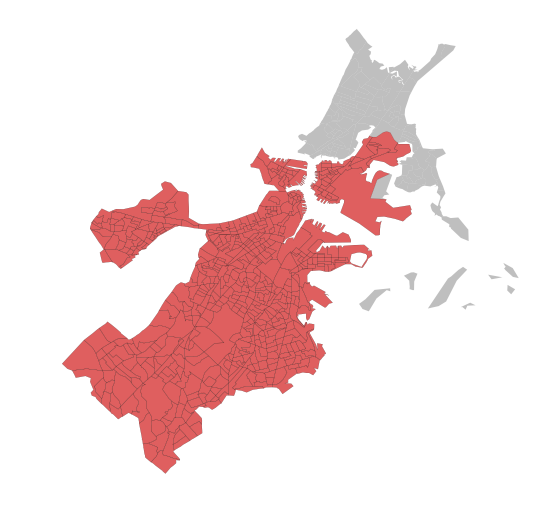

In [23]:
f, ax = plt.subplots(1, figsize=(9, 9))

suffolk.plot(color='grey', linewidth=0, ax=ax)
cb_db.plot(color='red', linewidth=0.1, ax=ax)

ax.set_axis_off()

plt.show()

In [24]:
# cluster data
km5 = cluster.KMeans(n_clusters=7)

In [25]:
km5cls = km5.fit(cb_db.drop(['geometry'], axis=1).values)

In [ ]:
f, ax = plt.subplots(1, figsize=(9, 9))

cb_db.assign(cl=km5cls.labels_)\
   .plot(column='cl', categorical=True, legend=True, \
         linewidth=0.1, edgecolor='white', ax=ax, cmap='Set2')

ax.set_axis_off()

plt.show()

In [ ]:
cl_pcts = dept_types_pct.rename(lambda x: str(int(x)))\
                          .reindex(cb_db['BG_ID'])\
                          .assign(cl=km5cls.labels_)\
                          .groupby('cl')\
                          .mean()

In [ ]:
f, ax = plt.subplots(1, figsize=(18, 9))
cl_pcts.plot(kind='barh', stacked=True, ax=ax, \
             cmap='Set2', linewidth=0)
ax.legend(ncol=1, loc="right");